In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

In [2]:
from scipy.interpolate import RectBivariateSpline
import numpy as np

In [3]:
from vaneska.interpolate import ScipyRectBivariateSpline

In [4]:
from lightkurve import KeplerTargetPixelFile

In [5]:
import tensorflow as tf

In [6]:
from vaneska.models import KeplerPRF

In [7]:
tpf = KeplerTargetPixelFile.from_archive('kepler-10b', quarter=5)

INFO: Found cached file ./mastDownload/Kepler/kplr011904151_lc_Q111111110111011101/kplr011904151-2010174085026_lpd-targ.fits.gz with expected size 4685387. [astroquery.query]


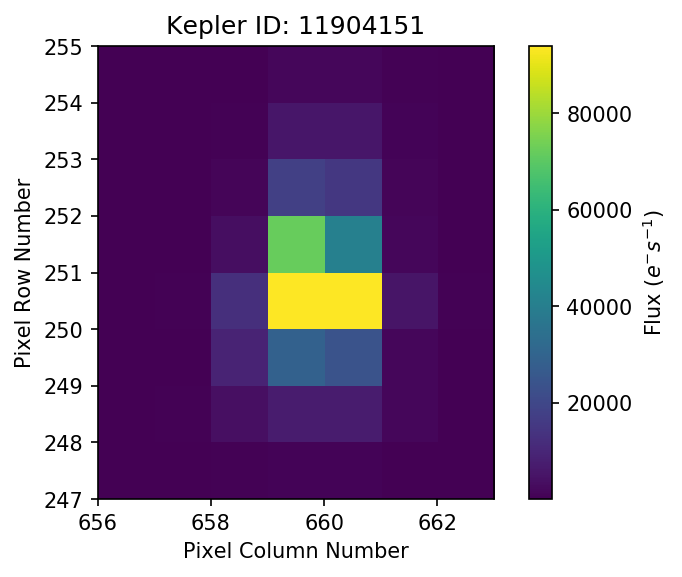

In [8]:
tpf.plot()

In [37]:
from lightkurve import PRFPhotometry, SceneModel

In [39]:
from oktopus import UniformPrior

In [38]:
scene = SceneModel(prfs=[tpf.get_prf_model()])

In [40]:
unif = UniformPrior(lb=[3e5, 658., 249., 100.],
                    ub=[7e5, 662., 253., 10e3])

In [41]:
phot = PRFPhotometry(scene_model=scene, prior=unif)

In [42]:
results = phot.fit(tpf_flux=tpf.flux + tpf.flux_bkg)

  0%|          | 0/4492 [00:00<?, ?it/s]/Users/jvmirca/anaconda3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
/Users/jvmirca/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
100%|██████████| 4492/4492 [02:13<00:00, 33.62it/s]


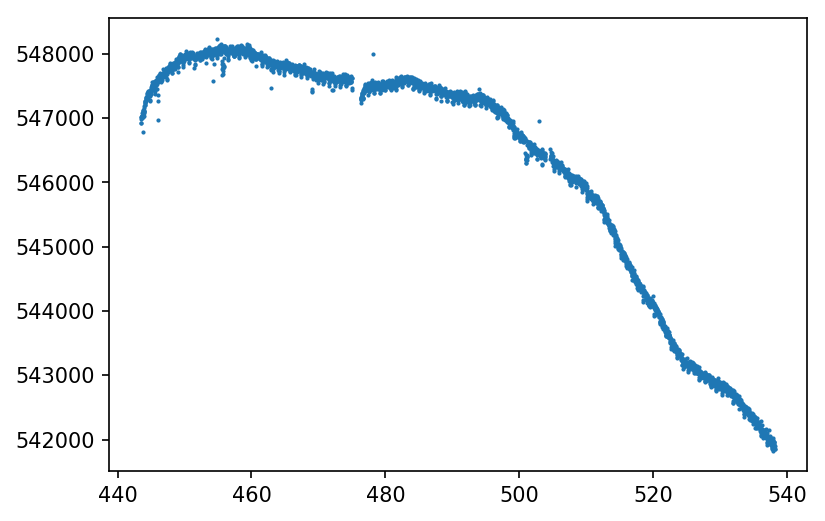

In [48]:
plt.plot(tpf.time, results[:, 0], 'o', markersize=1.)

In [9]:
prf = KeplerPRF(channel=tpf.channel, shape=tpf.shape[1:], column=tpf.column, row=tpf.row)

In [10]:
flux = tf.Variable(547055, dtype=tf.float64)
xc = tf.Variable(659.87, dtype=tf.float64)
yc = tf.Variable(250.74, dtype=tf.float64)
bkg = tf.Variable(212.52, dtype=tf.float64)

In [11]:
var_list = [flux, xc, yc, bkg]

In [12]:
model = prf(flux, xc, yc) + bkg
model = tf.reshape(model, shape=tpf.shape[1:])

In [13]:
model

<tf.Tensor 'Reshape:0' shape=(8, 7) dtype=float64>

In [14]:
sess = tf.Session()

In [15]:
sess.run(tf.global_variables_initializer())

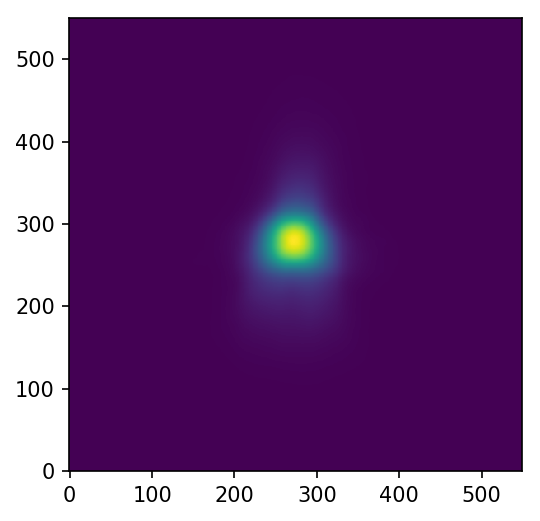

In [16]:
plt.imshow(prf.supersampled_prf, origin='lower')

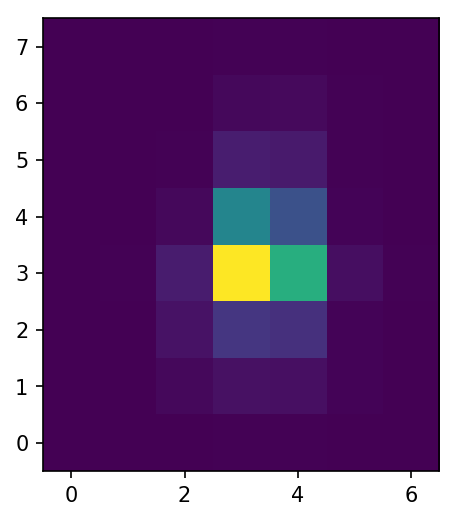

In [17]:
plt.imshow(sess.run(model), origin='lower')

In [49]:
data = tf.placeholder(dtype=tf.float64, shape=tpf.flux[0].shape)

In [50]:
loss = tf.reduce_sum(tf.subtract(model, tf.multiply(data, tf.log(model))))

In [51]:
grad = tf.gradients(loss, var_list)

In [52]:
sess.run(grad, feed_dict={data:tpf.flux[0] + tpf.flux_bkg[0]})

[-0.0064845514222284309,
 -92977.957140910847,
 -44691.358188445141,
 3.7985660434068977]

In [53]:
optimizer = tf.contrib.opt.ScipyOptimizerInterface(loss, var_list, method='powell')

In [54]:
import tqdm

In [ ]:
psf_flux = []
psf_xc = []
psf_yc = []
for n in tqdm.tqdm(range(len(tpf.time))):
    optimizer.minimize(session=sess, feed_dict={data:tpf.flux[n] + tpf.flux_bkg[n]})
    psf_flux.append(sess.run(flux))
    psf_xc.append(sess.run(xc))
    psf_yc.append(sess.run(yc))
    print(sess.run(grad, feed_dict={data:tpf.flux[n] + tpf.flux_bkg[n]}))

  0%|          | 0/4492 [00:00<?, ?it/s]/Users/jvmirca/anaconda3/lib/python3.6/site-packages/scipy/optimize/_minimize.py:415: RuntimeWarning: Method powell does not use gradient information (jac).
  RuntimeWarning)


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511108.770698
  Number of iterations: 2
  Number of functions evaluations: 91


  0%|          | 1/4492 [00:00<53:11,  1.41it/s]

[-7.5864417676912294e-05, -276.50265403064577, 0.45496155284126871, 2.3040640775628951e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5510920.136944
  Number of iterations: 1
  Number of functions evaluations: 45


  0%|          | 2/4492 [00:01<40:02,  1.87it/s]

[-8.3438328645811868e-06, 23.903321380679245, -1.6299488063541503, 2.5556874227450344e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511383.377277
  Number of iterations: 1
  Number of functions evaluations: 45


  0%|          | 3/4492 [00:01<35:29,  2.11it/s]

[-5.0736381911870194e-05, -5.3594681528893489, -10.800191311784147, 1.0939894562578267e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511830.355335
  Number of iterations: 1
  Number of functions evaluations: 45


  0%|          | 4/4492 [00:01<32:44,  2.29it/s]

[5.1978144534718662e-06, -20.63813951919019, 0.64439514060359215, 2.068745517824766e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511982.103935
  Number of iterations: 1
  Number of functions evaluations: 45


  0%|          | 5/4492 [00:02<31:01,  2.41it/s]

[4.5127719076163038e-05, -7.2300883164430161, 9.1371172402105003, -2.9024392232623875e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511765.758378
  Number of iterations: 1
  Number of functions evaluations: 44


  0%|          | 6/4492 [00:02<29:50,  2.51it/s]

[-6.945225071466974e-05, -58.717248344679774, -16.191160650791062, -8.5030410707953585e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511875.209788
  Number of iterations: 1
  Number of functions evaluations: 45


  0%|          | 7/4492 [00:02<28:59,  2.58it/s]

[1.3417921056487099e-05, -44.364695222443515, 2.3234207586883713, 2.7362059408231332e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511979.997084
  Number of iterations: 1
  Number of functions evaluations: 45


  0%|          | 8/4492 [00:03<28:21,  2.64it/s]

[9.3835659407438821e-07, -30.589954054197733, -0.18245287835816271, -6.182097180951196e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512285.045594
  Number of iterations: 1
  Number of functions evaluations: 45


  0%|          | 9/4492 [00:03<27:56,  2.67it/s]

[8.2482535444117905e-06, -44.224317269270614, 0.75844297006369743, 1.8209119037049248e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512067.740597
  Number of iterations: 1
  Number of functions evaluations: 45


  0%|          | 10/4492 [00:03<27:30,  2.72it/s]

[-2.4764870310981305e-05, 39.441486440572135, -4.1574005115035106, 1.2312510435430468e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511282.748671
  Number of iterations: 1
  Number of functions evaluations: 45


  0%|          | 11/4492 [00:04<27:12,  2.74it/s]

[-4.5840134774878874e-05, 40.409927750282804, -8.9625288924726192, 2.1134234334918567e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512750.979905
  Number of iterations: 1
  Number of functions evaluations: 44


  0%|          | 12/4492 [00:04<27:04,  2.76it/s]

[6.5537664960084452e-05, 31.929883997961952, 14.383983137613541, 2.5527370163258567e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511762.997446
  Number of iterations: 1
  Number of functions evaluations: 45


  0%|          | 13/4492 [00:04<26:56,  2.77it/s]

[-8.84821592918748e-05, 14.412082480171648, -18.730563936291219, -0.00023229801733759547]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511570.312434
  Number of iterations: 1
  Number of functions evaluations: 44


  0%|          | 14/4492 [00:05<26:50,  2.78it/s]

[0.00010245218521717087, -93.306217781638679, 22.385285826976542, 2.6516701203349591e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5508140.461118
  Number of iterations: 1
  Number of functions evaluations: 45


  0%|          | 15/4492 [00:05<26:54,  2.77it/s]

[-5.3391748545038309e-05, -71.458666162788177, -10.933810413731408, 5.987241548255362e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512187.476978
  Number of iterations: 1
  Number of functions evaluations: 45


  0%|          | 16/4492 [00:05<26:48,  2.78it/s]

[-4.9342302653051888e-05, -107.77705788846606, -12.333950275127791, 1.0004224576976029e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512738.413538
  Number of iterations: 1
  Number of functions evaluations: 45


  0%|          | 17/4492 [00:06<27:00,  2.76it/s]

[-2.3585759514502085e-05, -0.73963490425376222, -5.4896253577135212, 2.1943843471650126e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5513250.189786
  Number of iterations: 1
  Number of functions evaluations: 45


  0%|          | 18/4492 [00:06<26:53,  2.77it/s]

[1.5404732610579952e-05, -34.520667884951308, 2.7143751514031464, -3.9301689406245899e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512937.011806
  Number of iterations: 1
  Number of functions evaluations: 45


  0%|          | 19/4492 [00:06<26:49,  2.78it/s]

[6.190954021940108e-06, 39.438286735099609, 2.1107702171630081, 1.2769768966358619e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512679.736567
  Number of iterations: 1
  Number of functions evaluations: 44


  0%|          | 20/4492 [00:07<26:41,  2.79it/s]

[-3.0195209616042627e-05, -77.17375637093528, -7.0314856061449973, 2.6921824057613009e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512849.972076
  Number of iterations: 1
  Number of functions evaluations: 45


  0%|          | 21/4492 [00:07<26:31,  2.81it/s]

[1.6286222438383589e-05, -10.599173827875347, 2.9001963604641787, -3.3066515618962455e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512777.850830
  Number of iterations: 1
  Number of functions evaluations: 45


  0%|          | 22/4492 [00:07<26:23,  2.82it/s]

[-2.9600464810354554e-05, -3.1613025927072158, -5.2735474923811125, 2.0594296653686506e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511974.958781
  Number of iterations: 1
  Number of functions evaluations: 45


  1%|          | 23/4492 [00:08<26:17,  2.83it/s]

[-2.134501949678947e-05, -0.008727804941827344, -4.8168390135033405, 1.7770142518247489e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512485.225597
  Number of iterations: 1
  Number of functions evaluations: 44


  1%|          | 24/4492 [00:08<26:15,  2.84it/s]

[-3.0669413282020247e-05, -52.678121509122775, -6.7378230306803744, 2.5906137127273965e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512504.502006
  Number of iterations: 1
  Number of functions evaluations: 51


  1%|          | 25/4492 [00:08<26:27,  2.81it/s]

[1.2114729554726228e-06, -1.0217818518622153, -0.019722889655895415, 2.1025579902689273e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5513457.898783
  Number of iterations: 1
  Number of functions evaluations: 45


  1%|          | 26/4492 [00:09<26:24,  2.82it/s]

[-1.3226360423577131e-05, -24.705197728763778, -3.5203951268122182, 1.797085512955654e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5513275.931596
  Number of iterations: 1
  Number of functions evaluations: 45


  1%|          | 27/4492 [00:09<26:23,  2.82it/s]

[1.2879353659050324e-05, -7.2805251953113839, 2.4014269864110247, 3.5891046041847119e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5513587.954048
  Number of iterations: 1
  Number of functions evaluations: 45


  1%|          | 28/4492 [00:09<26:22,  2.82it/s]

[2.3523983703485976e-06, 29.417773832085004, 1.0268749883707642, 2.1489712720423881e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5513815.048660
  Number of iterations: 1
  Number of functions evaluations: 44


  1%|          | 29/4492 [00:10<26:27,  2.81it/s]

[-1.5064688564479269e-05, -62.121167600525951, -4.1230516969262681, 1.6596317390038529e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514297.311598
  Number of iterations: 1
  Number of functions evaluations: 45


  1%|          | 30/4492 [00:10<26:28,  2.81it/s]

[-3.1885292161689532e-05, 8.2185438531623731, -6.1654177213640651, 2.6562930208973157e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514004.338925
  Number of iterations: 1
  Number of functions evaluations: 45


  1%|          | 31/4492 [00:11<26:31,  2.80it/s]

[1.8908018637501037e-05, 45.989914580861296, 4.807253927570855, -2.8256071904597668e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514077.007181
  Number of iterations: 1
  Number of functions evaluations: 44


  1%|          | 32/4492 [00:11<26:29,  2.81it/s]

[-2.4838333484972393e-05, -78.534493925578317, -5.4674799124550191, 2.4500988033859805e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514170.210137
  Number of iterations: 1
  Number of functions evaluations: 45


  1%|          | 33/4492 [00:11<26:32,  2.80it/s]

[4.7656155099749103e-06, -20.801995499580244, 0.47647700468769472, 2.162411504669226e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514307.882244
  Number of iterations: 1
  Number of functions evaluations: 45


  1%|          | 34/4492 [00:12<26:30,  2.80it/s]

[-2.596696852576099e-05, -9.6648312877327953, -5.1702769039220584, 2.07237142995087e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514512.057503
  Number of iterations: 1
  Number of functions evaluations: 44


  1%|          | 35/4492 [00:12<26:31,  2.80it/s]

[-3.8038888360222844e-06, -89.097736958952737, 0.46173783057747642, 2.7617950801084312e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514873.527669
  Number of iterations: 1
  Number of functions evaluations: 44


  1%|          | 36/4492 [00:12<26:28,  2.81it/s]

[2.2730764189666727e-05, -5.8955085642055565, 4.7178370599285699, 6.3757861557323103e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514851.624023
  Number of iterations: 1
  Number of functions evaluations: 45


  1%|          | 37/4492 [00:13<26:27,  2.81it/s]

[-6.2035460362101953e-05, -34.470021398407425, -13.200188567154328, -2.0962984803918339e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514474.269405
  Number of iterations: 1
  Number of functions evaluations: 53


  1%|          | 38/4492 [00:13<26:34,  2.79it/s]

[9.1628185968145245e-06, -13.815114711521346, 1.715275840859249, 1.024600701537981e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514882.138375
  Number of iterations: 1
  Number of functions evaluations: 45


  1%|          | 39/4492 [00:13<26:34,  2.79it/s]

[5.4342704613836654e-06, 23.66749273580308, 1.2853204451948841, 1.9634122634837325e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514851.337162
  Number of iterations: 1
  Number of functions evaluations: 45


  1%|          | 40/4492 [00:14<26:33,  2.79it/s]

[-5.3109618637765116e-05, -20.543320562661847, -10.487461025564699, 7.158537129148268e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514599.751613
  Number of iterations: 1
  Number of functions evaluations: 44


  1%|          | 41/4492 [00:14<26:38,  2.79it/s]

[2.5811491878240111e-05, -2.0825735359444479, 4.8352562705658784, -4.4072321945809456e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515033.805101
  Number of iterations: 1
  Number of functions evaluations: 45


  1%|          | 42/4492 [00:15<26:36,  2.79it/s]

[2.5616043155189498e-05, -38.877138460020433, 3.8955190647284326, -3.4076298420782081e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514949.948764
  Number of iterations: 1
  Number of functions evaluations: 45


  1%|          | 43/4492 [00:15<26:37,  2.79it/s]

[-3.340807539719149e-05, -25.684480296203674, -6.7635259662729368, 2.7820234452469172e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515358.695328
  Number of iterations: 1
  Number of functions evaluations: 45


  1%|          | 44/4492 [00:15<26:39,  2.78it/s]

[7.2879071396077938e-05, 29.247991018391076, 14.150971779168685, 2.7701046668160423e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515001.860971
  Number of iterations: 1
  Number of functions evaluations: 44


  1%|          | 45/4492 [00:16<26:37,  2.78it/s]

[-8.594370324773587e-05, -54.390114268225716, -17.339772920047835, -0.00022175431332061013]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515762.568738
  Number of iterations: 1
  Number of functions evaluations: 50


  1%|          | 46/4492 [00:16<26:36,  2.78it/s]

[3.1755562753822339e-05, -2.7526364647465016, 6.3247289677638037, -7.8987413706488319e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515101.020989
  Number of iterations: 1
  Number of functions evaluations: 45


  1%|          | 47/4492 [00:16<26:35,  2.79it/s]

[2.2639393508641983e-06, 41.688822010198237, 1.015072229442012, -1.6167940982136919e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515773.697488
  Number of iterations: 1
  Number of functions evaluations: 45


  1%|          | 48/4492 [00:17<26:32,  2.79it/s]

[-1.7088192667130686e-05, -55.897095764168625, -4.4103342206835805, 1.3666100691978045e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515928.540508
  Number of iterations: 1
  Number of functions evaluations: 45


  1%|          | 49/4492 [00:17<26:33,  2.79it/s]

[-5.5959492760646046e-06, 5.4358712460507377, -0.95969297150804778, 2.8134480371533321e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515491.299480
  Number of iterations: 1
  Number of functions evaluations: 45


  1%|          | 50/4492 [00:17<26:33,  2.79it/s]

[9.3971941235865275e-06, 41.218276662831613, 2.5935545438442205, 8.0569093355853383e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515268.316283
  Number of iterations: 1
  Number of functions evaluations: 44


  1%|          | 51/4492 [00:18<26:30,  2.79it/s]

[-5.2184897539418046e-06, -86.247401464391714, -0.87107589754123183, 2.7857800413699785e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515639.621732
  Number of iterations: 1
  Number of functions evaluations: 45


  1%|          | 52/4492 [00:18<26:28,  2.80it/s]

[-7.7328592664963752e-06, 36.99443657244592, -0.96438892955848132, 2.7710178340134561e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515362.120992
  Number of iterations: 1
  Number of functions evaluations: 45


  1%|          | 53/4492 [00:18<26:26,  2.80it/s]

[-6.4297014803352606e-06, 29.468651309698089, -0.75825426813025842, 2.8102139106533919e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515578.226522
  Number of iterations: 1
  Number of functions evaluations: 44


  1%|          | 54/4492 [00:19<26:28,  2.79it/s]

[-7.4276549053584572e-05, -55.87837552646215, -15.425602341520062, -0.00011898648203534368]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516110.697519
  Number of iterations: 1
  Number of functions evaluations: 44


  1%|          | 55/4492 [00:19<26:25,  2.80it/s]

[6.5098176268147193e-05, -35.388022104081301, 11.792390311004056, -2.1232600166398718e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515491.652875
  Number of iterations: 1
  Number of functions evaluations: 44


  1%|          | 56/4492 [00:19<26:22,  2.80it/s]

[-3.8417434734643909e-05, 2.8825078433810631, -7.4813780562744796, 2.6587618287776671e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5523041.084507
  Number of iterations: 1
  Number of functions evaluations: 48


  1%|▏         | 57/4492 [00:20<26:23,  2.80it/s]

[0.0011889533101458721, -139.88526973830812, 222.31745972703902, 0.0052827204393178784]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515875.691388
  Number of iterations: 1
  Number of functions evaluations: 48


  1%|▏         | 58/4492 [00:20<26:24,  2.80it/s]

[-0.0011591330804407484, 141.37775050142045, -216.03818767775738, 0.0066182741460958372]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515795.204988
  Number of iterations: 1
  Number of functions evaluations: 46


  1%|▏         | 59/4492 [00:21<26:24,  2.80it/s]

[2.3977300303445852e-05, -25.469275012272192, 3.9512182892140117, -3.3797670481172659e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515668.279498
  Number of iterations: 1
  Number of functions evaluations: 45


  1%|▏         | 60/4492 [00:21<26:22,  2.80it/s]

[-6.3704634478130989e-05, -40.76599978203285, -12.548385357617008, 1.3186974625600811e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515698.929423
  Number of iterations: 1
  Number of functions evaluations: 45


  1%|▏         | 61/4492 [00:21<26:22,  2.80it/s]

[4.9219752026588223e-06, 57.5654292192512, 2.3472134561379789, 1.3892518238134421e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515808.968421
  Number of iterations: 1
  Number of functions evaluations: 45


  1%|▏         | 62/4492 [00:22<26:20,  2.80it/s]

[1.4070523056458097e-05, -38.417162126923358, 1.9166397859880817, 1.0985361179605135e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514988.170535
  Number of iterations: 1
  Number of functions evaluations: 45


  1%|▏         | 63/4492 [00:22<26:21,  2.80it/s]

[3.0316070922339032e-05, -5.3902134618283526, 5.4960148068930721, -6.7270139501030002e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514818.067390
  Number of iterations: 1
  Number of functions evaluations: 45


  1%|▏         | 64/4492 [00:22<26:19,  2.80it/s]

[2.2194173358023803e-05, -41.399003290501241, 2.6558560239882354, -1.2400593639383395e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515323.851013
  Number of iterations: 1
  Number of functions evaluations: 45


  1%|▏         | 65/4492 [00:23<26:18,  2.80it/s]

[-5.8074899443167488e-05, -25.120030134088665, -11.654480046519893, 2.4600010220421353e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515908.448434
  Number of iterations: 1
  Number of functions evaluations: 45


  1%|▏         | 66/4492 [00:23<26:16,  2.81it/s]

[-8.9700523229789206e-06, -38.000786263247846, -2.8168437656368042, 2.5231326054808711e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516263.335663
  Number of iterations: 1
  Number of functions evaluations: 45


  1%|▏         | 67/4492 [00:23<26:13,  2.81it/s]

[1.9726422481599476e-05, 34.524167858249257, 4.8020737794704473, -3.4481710741718352e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516215.790226
  Number of iterations: 1
  Number of functions evaluations: 47


  2%|▏         | 68/4492 [00:24<26:11,  2.81it/s]

[1.4195140899796004e-05, -2.027964638443791, 2.4609236399664951, 1.2913778770773376e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516218.276621
  Number of iterations: 1
  Number of functions evaluations: 45


  2%|▏         | 69/4492 [00:24<26:11,  2.81it/s]

[-3.771789219894281e-05, -10.231199721476969, -7.4398951206821948, 2.7483707993214423e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515992.754440
  Number of iterations: 1
  Number of functions evaluations: 45


  2%|▏         | 70/4492 [00:24<26:11,  2.81it/s]

[-2.2984832916406184e-06, 26.569484487009049, 0.14547316744756245, -7.4376754166660675e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516093.671535
  Number of iterations: 1
  Number of functions evaluations: 44


  2%|▏         | 71/4492 [00:25<26:11,  2.81it/s]

[7.0619886446496999e-06, -66.480982898657203, -0.3396706393596105, 2.1212050463903509e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515788.811519
  Number of iterations: 1
  Number of functions evaluations: 45


  2%|▏         | 72/4492 [00:25<26:13,  2.81it/s]

[7.23038181063302e-06, -23.069712672957394, 0.70631954231430427, 1.8616367607249273e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515859.769017
  Number of iterations: 1
  Number of functions evaluations: 45


  2%|▏         | 73/4492 [00:26<26:15,  2.80it/s]

[-6.0849099448190974e-05, -37.166419942097946, -12.082510915151943, 1.4687570489280155e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516356.624210
  Number of iterations: 1
  Number of functions evaluations: 45


  2%|▏         | 74/4492 [00:26<26:16,  2.80it/s]

[1.6387943535574843e-05, -22.309428860806293, 2.8548437413610372, -1.3221508508132196e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515947.186319
  Number of iterations: 1
  Number of functions evaluations: 45


  2%|▏         | 75/4492 [00:26<26:20,  2.80it/s]

[4.0745993541302199e-05, 12.468765138571143, 7.388240991082057, -4.9933259166246025e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516696.593910
  Number of iterations: 1
  Number of functions evaluations: 45


  2%|▏         | 76/4492 [00:27<26:23,  2.79it/s]

[-5.1188751353349084e-05, -4.7687212837267907, -9.5344725206305156, 9.1999589542091087e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516551.811512
  Number of iterations: 1
  Number of functions evaluations: 45


  2%|▏         | 77/4492 [00:27<26:22,  2.79it/s]

[2.9131570282175598e-05, 12.692498509617508, 5.3799806972729129, -5.8312605954791152e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516319.146469
  Number of iterations: 1
  Number of functions evaluations: 45


  2%|▏         | 78/4492 [00:27<26:22,  2.79it/s]

[-8.6999290431315213e-06, -11.343034245441231, -1.7976976050940721, 2.7789089895535746e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517670.982422
  Number of iterations: 1
  Number of functions evaluations: 45


  2%|▏         | 79/4492 [00:28<26:23,  2.79it/s]

[2.8180876211177444e-06, -10.964926426133388, 0.25054179896324058, -1.6220994729199134e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516762.335941
  Number of iterations: 1
  Number of functions evaluations: 50


  2%|▏         | 80/4492 [00:28<26:25,  2.78it/s]

[6.0231432516139223e-05, -6.7502794744505081, 11.040656730127012, 2.0774135569667784e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517147.205655
  Number of iterations: 1
  Number of functions evaluations: 45


  2%|▏         | 81/4492 [00:29<26:25,  2.78it/s]

[-5.0827524473697795e-05, 9.3393013413260633, -9.6513912995505962, 7.2788109953036972e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517131.335630
  Number of iterations: 1
  Number of functions evaluations: 45


  2%|▏         | 82/4492 [00:29<26:26,  2.78it/s]

[-3.3627721547365742e-05, 1.9471446632451261, -5.8925067488435161, 2.7794269867653654e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517366.457588
  Number of iterations: 1
  Number of functions evaluations: 45


  2%|▏         | 83/4492 [00:29<26:27,  2.78it/s]

[6.2192310384285091e-05, 17.778339428023628, 11.824040133533344, 2.3313834563332136e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517608.780981
  Number of iterations: 1
  Number of functions evaluations: 45


  2%|▏         | 84/4492 [00:30<26:26,  2.78it/s]

[-6.2931971984545379e-05, 5.9206769451370747, -10.976526087653838, 2.9313994873825244e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517341.056439
  Number of iterations: 1
  Number of functions evaluations: 45


  2%|▏         | 85/4492 [00:30<26:24,  2.78it/s]

[3.5125925098765387e-05, -37.758944903126121, 5.1874807467156643, -7.9503759632615356e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517102.734605
  Number of iterations: 1
  Number of functions evaluations: 45


  2%|▏         | 86/4492 [00:30<26:23,  2.78it/s]

[-5.9021441629048682e-05, 9.5855275115977747, -10.450607182514432, 4.660689678992469e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517178.237798
  Number of iterations: 1
  Number of functions evaluations: 45


  2%|▏         | 87/4492 [00:31<26:21,  2.79it/s]

[-3.9705751309626613e-06, -52.467447555484341, -2.2029832057141903, 2.8726916169174999e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517525.689213
  Number of iterations: 1
  Number of functions evaluations: 45


  2%|▏         | 88/4492 [00:31<26:19,  2.79it/s]

[4.7272782077096773e-05, 8.792811210826585, 9.0112970057562052, -1.0247045651889941e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516977.294210
  Number of iterations: 1
  Number of functions evaluations: 45


  2%|▏         | 89/4492 [00:31<26:18,  2.79it/s]

[-2.3844688909259795e-05, 41.922428416904495, -3.9062442607028061, 2.0164574693226633e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517562.440856
  Number of iterations: 1
  Number of functions evaluations: 44


  2%|▏         | 90/4492 [00:32<26:17,  2.79it/s]

[-2.9377554402690992e-06, -75.097206599797573, -2.5286051608200069, 2.879231765784418e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517242.436792
  Number of iterations: 1
  Number of functions evaluations: 45


  2%|▏         | 91/4492 [00:32<26:15,  2.79it/s]

[-3.9954501824178597e-05, 21.195355024340643, -6.8535684607304574, 2.7767898663877411e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516758.684108
  Number of iterations: 1
  Number of functions evaluations: 45


  2%|▏         | 92/4492 [00:32<26:13,  2.80it/s]

[3.3308743073699049e-05, -12.170211758512778, 5.7427185629858286, -8.4638633131461916e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517518.881920
  Number of iterations: 1
  Number of functions evaluations: 45


  2%|▏         | 93/4492 [00:33<26:12,  2.80it/s]

[-4.2704071746649599e-05, -40.58838026794092, -8.462363744238246, 2.5973560279668462e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517282.969752
  Number of iterations: 1
  Number of functions evaluations: 45


  2%|▏         | 94/4492 [00:33<26:11,  2.80it/s]

[2.1561807524861018e-05, 43.604809686657063, 4.4064529447896348, -2.1115019386952483e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517532.194208
  Number of iterations: 1
  Number of functions evaluations: 45


  2%|▏         | 95/4492 [00:33<26:10,  2.80it/s]

[1.8108564801964065e-05, 5.3891937841240178, 3.3126166217789432, -1.2421055548772486e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517180.805017
  Number of iterations: 1
  Number of functions evaluations: 45


  2%|▏         | 96/4492 [00:34<26:09,  2.80it/s]

[1.2495484866206601e-05, -4.5448393410783865, 1.9117975066565123, 8.1760825513255142e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517003.253799
  Number of iterations: 1
  Number of functions evaluations: 51


  2%|▏         | 97/4492 [00:34<26:12,  2.79it/s]

[-2.2593780449736527e-05, 41.727284315873931, -3.1713626946057047, 1.2204423425421496e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517158.834087
  Number of iterations: 1
  Number of functions evaluations: 45


  2%|▏         | 98/4492 [00:35<26:12,  2.79it/s]

[3.332332072746285e-05, -38.087090034773155, 5.3551603690339107, -8.1429581415770613e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517387.322985
  Number of iterations: 1
  Number of functions evaluations: 45


  2%|▏         | 99/4492 [00:35<26:12,  2.79it/s]

[-4.5998599669866934e-05, -50.290257946217025, -9.9286228878099791, 1.505157699133175e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517119.175397
  Number of iterations: 1
  Number of functions evaluations: 45


  2%|▏         | 100/4492 [00:35<26:15,  2.79it/s]

[4.4606342562618015e-05, 19.858297499619766, 8.4507183447603893, -2.6416678084784095e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516970.716165
  Number of iterations: 1
  Number of functions evaluations: 45


  2%|▏         | 101/4492 [00:36<26:17,  2.78it/s]

[-1.4927828090809114e-05, -7.5913497880119394, -2.2884836134253419, 2.5884453511926253e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517655.512602
  Number of iterations: 1
  Number of functions evaluations: 45


  2%|▏         | 102/4492 [00:36<26:21,  2.78it/s]

[-2.1776286287334377e-05, -3.2641018859694668, -4.6322114990180125, 2.0268518725496953e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515751.221685
  Number of iterations: 1
  Number of functions evaluations: 45


  2%|▏         | 103/4492 [00:37<26:24,  2.77it/s]

[2.501055535599709e-05, 13.21675489532754, 4.6010524916746363, -3.8033825003336297e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516454.477322
  Number of iterations: 1
  Number of functions evaluations: 45


  2%|▏         | 104/4492 [00:37<26:26,  2.77it/s]

[-2.8594125041983554e-05, -40.709400215153437, -6.1936265305266716, 2.5871256098985995e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516125.115363
  Number of iterations: 1
  Number of functions evaluations: 45


  2%|▏         | 105/4492 [00:38<26:28,  2.76it/s]

[-1.6924513789537583e-05, -50.568144853370995, -4.1448997185543703, 1.8549037794968193e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516987.223356
  Number of iterations: 1
  Number of functions evaluations: 45


  2%|▏         | 106/4492 [00:38<26:29,  2.76it/s]

[1.3590092601890522e-05, 30.879279743456209, 3.1185198549210327, -6.2254603705458322e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517533.560225
  Number of iterations: 1
  Number of functions evaluations: 45


  2%|▏         | 107/4492 [00:38<26:30,  2.76it/s]

[-2.0815042898602622e-05, -52.321066744795644, -5.0693317119312269, 1.369001079054577e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517388.383589
  Number of iterations: 1
  Number of functions evaluations: 46


  2%|▏         | 108/4492 [00:39<26:31,  2.76it/s]

[1.9327363784809107e-05, 23.034251772653079, 4.2569278521677916, -2.6350177670497743e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516271.411981
  Number of iterations: 1
  Number of functions evaluations: 45


  2%|▏         | 109/4492 [00:39<26:30,  2.76it/s]

[1.6363452622856871e-05, 19.716415986737957, 3.6494175919142435, -1.459362608757786e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516646.212194
  Number of iterations: 1
  Number of functions evaluations: 47


  2%|▏         | 110/4492 [00:39<26:29,  2.76it/s]

[-4.2563297504406329e-05, -34.400846704944342, -9.3546408676229476, 1.762915785097352e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517117.006320
  Number of iterations: 1
  Number of functions evaluations: 45


  2%|▏         | 111/4492 [00:40<26:28,  2.76it/s]

[-3.005754240372957e-05, 36.527345529377271, -5.0431351886509219, 2.7797344996249862e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517424.804612
  Number of iterations: 1
  Number of functions evaluations: 45


  2%|▏         | 112/4492 [00:40<26:27,  2.76it/s]

[6.2395298823418946e-05, 2.5176123299402207, 11.389680036698337, 2.2974726010871471e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517415.791506
  Number of iterations: 1
  Number of functions evaluations: 45


  3%|▎         | 113/4492 [00:40<26:27,  2.76it/s]

[-6.3354158220877213e-05, -28.872881834857708, -12.524527602829039, -1.2548435456616325e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517634.523831
  Number of iterations: 1
  Number of functions evaluations: 45


  3%|▎         | 114/4492 [00:41<26:26,  2.76it/s]

[2.9297650233377735e-05, -28.719204486503259, 4.8449682738028059, -7.0397306686120764e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517240.374751
  Number of iterations: 1
  Number of functions evaluations: 45


  3%|▎         | 115/4492 [00:41<26:24,  2.76it/s]

[-3.339614126714012e-05, 55.401907097374078, -4.6506849257239082, 2.7394702703076312e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518262.046611
  Number of iterations: 1
  Number of functions evaluations: 45


  3%|▎         | 116/4492 [00:41<26:22,  2.76it/s]

[3.1618162679087833e-05, -6.8175628148646865, 5.2972956679150229, -6.9133401486509705e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517414.339313
  Number of iterations: 1
  Number of functions evaluations: 45


  3%|▎         | 117/4492 [00:42<26:21,  2.77it/s]

[2.0267466137696179e-05, -11.3280887333176, 3.6098552404437214, -2.6897181684137905e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516241.282584
  Number of iterations: 1
  Number of functions evaluations: 45


  3%|▎         | 118/4492 [00:42<26:19,  2.77it/s]

[-6.9595596123550249e-05, -10.897301169451566, -12.856057086381043, -4.4319790191926778e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515966.165026
  Number of iterations: 1
  Number of functions evaluations: 45


  3%|▎         | 119/4492 [00:42<26:17,  2.77it/s]

[5.0047947104387216e-05, -65.77579740724741, 7.2099680452392931, -1.3684031827776444e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517299.069532
  Number of iterations: 1
  Number of functions evaluations: 45


  3%|▎         | 120/4492 [00:43<26:16,  2.77it/s]

[-2.0789998940228503e-05, -14.237495553986264, -3.6565994677403069, 1.6184375218997182e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509662.529362
  Number of iterations: 1
  Number of functions evaluations: 46


  3%|▎         | 121/4492 [00:43<26:14,  2.78it/s]

[5.4264655001039566e-05, 56.872914208223392, 8.3923938385287329, -4.9112330118394887e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5513493.279920
  Number of iterations: 1
  Number of functions evaluations: 44


  3%|▎         | 122/4492 [00:43<26:12,  2.78it/s]

[-5.7618487075750124e-05, -134.61114247135947, -13.139487209868093, 2.4710494467949928e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5513537.010901
  Number of iterations: 1
  Number of functions evaluations: 45


  3%|▎         | 123/4492 [00:44<26:10,  2.78it/s]

[-2.2908622213436459e-05, 23.233657221776866, -2.8712003185191861, 1.6373371271583004e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516951.346523
  Number of iterations: 1
  Number of functions evaluations: 46


  3%|▎         | 124/4492 [00:44<26:09,  2.78it/s]

[3.2145806155173783e-05, -9.0572254055964549, 5.4439515823287365, -7.6616247620120426e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518137.087006
  Number of iterations: 1
  Number of functions evaluations: 45


  3%|▎         | 125/4492 [00:44<26:07,  2.79it/s]

[-2.395027294939487e-05, 17.645642958897952, -4.8709206040020945, 2.5734957080358889e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517618.116808
  Number of iterations: 1
  Number of functions evaluations: 50


  3%|▎         | 126/4492 [00:45<26:07,  2.79it/s]

[-6.017094381200426e-06, 28.819968770266314, -0.41022298307507299, 2.9252112926259066e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517517.235988
  Number of iterations: 1
  Number of functions evaluations: 45


  3%|▎         | 127/4492 [00:45<26:05,  2.79it/s]

[1.4277167201330078e-05, -48.862074927284993, 0.72053882350519416, 1.1018890326175423e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518244.444699
  Number of iterations: 1
  Number of functions evaluations: 45


  3%|▎         | 128/4492 [00:45<26:03,  2.79it/s]

[-2.7929335640951118e-05, -1.9349309655494835, -4.9815908612599742, 2.3301851493129355e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518187.675988
  Number of iterations: 1
  Number of functions evaluations: 45


  3%|▎         | 129/4492 [00:46<26:01,  2.79it/s]

[2.1933214166247259e-05, 23.80321510670683, 4.7346650904019043, -3.7429138935896056e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518313.168126
  Number of iterations: 1
  Number of functions evaluations: 45


  3%|▎         | 130/4492 [00:46<26:00,  2.80it/s]

[-4.1742192829079088e-05, -43.189269933670403, -8.7618853880758252, 2.5373951693552499e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518626.318298
  Number of iterations: 1
  Number of functions evaluations: 45


  3%|▎         | 131/4492 [00:46<25:58,  2.80it/s]

[2.0296624082118825e-05, -8.052284653696006, 3.5908880837087054, -2.5667143346064236e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517906.469957
  Number of iterations: 1
  Number of functions evaluations: 45


  3%|▎         | 132/4492 [00:47<25:57,  2.80it/s]

[-1.506282139160809e-05, 21.350567939965913, -2.8218049461593182, 1.6586637215709743e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518496.509517
  Number of iterations: 1
  Number of functions evaluations: 45


  3%|▎         | 133/4492 [00:47<25:55,  2.80it/s]

[2.98395286213839e-05, -51.12424958049769, 3.7046326131239766, -5.2081734432274374e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518087.280365
  Number of iterations: 1
  Number of functions evaluations: 45


  3%|▎         | 134/4492 [00:47<25:53,  2.80it/s]

[-6.2566172322051604e-05, 4.4261166616806804, -11.623318413749075, -3.4366300603050348e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517593.809620
  Number of iterations: 1
  Number of functions evaluations: 45


  3%|▎         | 135/4492 [00:48<25:52,  2.81it/s]

[2.940375258829106e-06, 19.734358675444582, 1.1194882860381767, 2.2455596527692911e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518809.186481
  Number of iterations: 1
  Number of functions evaluations: 45


  3%|▎         | 136/4492 [00:48<25:54,  2.80it/s]

[1.5433909352715984e-05, -35.906873914827429, 1.9489714224673662, -4.0545695906279988e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518106.302990
  Number of iterations: 1
  Number of functions evaluations: 45


  3%|▎         | 137/4492 [00:48<25:53,  2.80it/s]

[3.0729273208139445e-05, 13.792290382785723, 5.8641425276364316, -7.5376720342967829e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518161.492223
  Number of iterations: 1
  Number of functions evaluations: 45


  3%|▎         | 138/4492 [00:49<25:53,  2.80it/s]

[-4.326009741074683e-05, -12.404991248396527, -8.3741007112748775, 2.3112490145860143e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518080.419748
  Number of iterations: 1
  Number of functions evaluations: 45


  3%|▎         | 139/4492 [00:49<25:54,  2.80it/s]

[1.4360135374613149e-05, -40.496122208503493, 1.8899484711546393, -1.1969129027900038e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518203.895437
  Number of iterations: 1
  Number of functions evaluations: 45


  3%|▎         | 140/4492 [00:50<25:55,  2.80it/s]

[-1.7973899390907357e-05, -7.5940264257073977, -3.5486945640332124, 1.4238011512013315e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518276.805462
  Number of iterations: 1
  Number of functions evaluations: 44


  3%|▎         | 141/4492 [00:50<25:57,  2.79it/s]

[6.5854109417938858e-05, 32.266419479079104, 12.59278945477854, 2.7735104216608519e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517975.985825
  Number of iterations: 1
  Number of functions evaluations: 45


  3%|▎         | 142/4492 [00:50<25:58,  2.79it/s]

[-6.9677216345010243e-05, -54.105165546110584, -13.552483369465335, -6.8695739453117355e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518254.665636
  Number of iterations: 1
  Number of functions evaluations: 45


  3%|▎         | 143/4492 [00:51<25:57,  2.79it/s]

[2.1741381799554246e-05, 2.7124073120412504, 3.963115639409807, -2.9756414951731536e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517349.458735
  Number of iterations: 1
  Number of functions evaluations: 45


  3%|▎         | 144/4492 [00:51<25:56,  2.79it/s]

[-8.1590695342245029e-07, 5.8972395318141935, -0.091080951679032296, 9.4008919671040303e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517098.090560
  Number of iterations: 1
  Number of functions evaluations: 45


  3%|▎         | 145/4492 [00:51<25:55,  2.80it/s]

[-6.0508380146344007e-05, 24.083100926080988, -10.892222900434717, 1.6278992922114099e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517470.054172
  Number of iterations: 1
  Number of functions evaluations: 45


  3%|▎         | 146/4492 [00:52<25:53,  2.80it/s]

[7.2901852279715768e-05, -4.9303211345672935, 13.414586256958501, 2.8373397602976524e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518359.704277
  Number of iterations: 1
  Number of functions evaluations: 45


  3%|▎         | 147/4492 [00:52<25:52,  2.80it/s]

[-4.1534185487974128e-05, -18.558096173027025, -7.8721000756067951, 2.5624601063478636e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518135.369520
  Number of iterations: 1
  Number of functions evaluations: 44


  3%|▎         | 148/4492 [00:52<25:50,  2.80it/s]

[1.0628670654038753e-05, -23.627461533233145, 1.4978880551807379, 1.2734430064664792e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517656.319048
  Number of iterations: 1
  Number of functions evaluations: 45


  3%|▎         | 149/4492 [00:53<25:49,  2.80it/s]

[-8.3052053962660854e-06, 18.739705327936008, -1.2628312432552775, 2.9126324796124869e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518227.135580
  Number of iterations: 1
  Number of functions evaluations: 45


  3%|▎         | 150/4492 [00:53<25:47,  2.81it/s]

[3.645731039758713e-05, -31.128628105212556, 6.1502652557719557, -7.1540633694633371e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518473.554143
  Number of iterations: 1
  Number of functions evaluations: 51


  3%|▎         | 151/4492 [00:53<25:47,  2.81it/s]

[-6.5902256348571338e-05, 7.1604876038863949, -11.941343685019092, -2.2186517541822326e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518713.645421
  Number of iterations: 1
  Number of functions evaluations: 46


  3%|▎         | 152/4492 [00:54<25:46,  2.81it/s]

[0.00018362190141336682, -22.913053624158238, 33.421698178506631, -0.00071352600784402309]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518590.946905
  Number of iterations: 1
  Number of functions evaluations: 46


  3%|▎         | 153/4492 [00:54<25:45,  2.81it/s]

[-0.00016266149658735341, -6.293871129634681, -29.944830213706155, 0.00087538704805112388]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518167.835727
  Number of iterations: 1
  Number of functions evaluations: 45


  3%|▎         | 154/4492 [00:54<25:43,  2.81it/s]

[2.7785719370323515e-05, 23.895065916097337, 5.333038773991575, -6.3325728937635439e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518216.857429
  Number of iterations: 1
  Number of functions evaluations: 45


  3%|▎         | 155/4492 [00:55<25:42,  2.81it/s]

[-9.1922356186633497e-07, 12.081261534550322, 0.22914944440890395, 6.2433647785020696e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518929.769681
  Number of iterations: 1
  Number of functions evaluations: 44


  3%|▎         | 156/4492 [00:55<25:41,  2.81it/s]

[4.2646380466565721e-05, -64.198809846243876, 6.9288357468321919, -4.1736828374605572e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518255.413720
  Number of iterations: 1
  Number of functions evaluations: 45


  3%|▎         | 157/4492 [00:55<25:39,  2.82it/s]

[-6.2840327083854564e-05, 22.455056740445798, -11.21396075719349, 6.3428730925352284e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518719.030353
  Number of iterations: 1
  Number of functions evaluations: 45


  4%|▎         | 158/4492 [00:56<25:38,  2.82it/s]

[5.0425418436491828e-06, 4.853149514314282, 0.80725506269118341, 2.2311687599141372e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518929.772279
  Number of iterations: 1
  Number of functions evaluations: 44


  4%|▎         | 159/4492 [00:56<25:36,  2.82it/s]

[8.2354932541871609e-06, -65.324878124340557, 0.46890067301865201, 2.0664190783281633e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518716.461545
  Number of iterations: 1
  Number of functions evaluations: 45


  4%|▎         | 160/4492 [00:56<25:35,  2.82it/s]

[9.9630655055037848e-06, 9.9373341227314995, 1.808691536223705, 1.1753331254915622e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518772.391986
  Number of iterations: 1
  Number of functions evaluations: 44


  4%|▎         | 161/4492 [00:57<25:34,  2.82it/s]

[-1.4540986467787183e-05, 8.9846721387643811, -2.4244103523506055, 2.3790008626289882e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518837.184288
  Number of iterations: 1
  Number of functions evaluations: 45


  4%|▎         | 162/4492 [00:57<25:32,  2.83it/s]

[-1.0001345024015368e-05, 9.1637269685838874, -1.3397396661530365, 2.9183301112123416e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518977.731947
  Number of iterations: 1
  Number of functions evaluations: 45


  4%|▎         | 163/4492 [00:57<25:31,  2.83it/s]

[-6.878154565928031e-05, 8.5820387263261182, -12.691880634782137, -5.8897206296593119e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518563.890283
  Number of iterations: 1
  Number of functions evaluations: 45


  4%|▎         | 164/4492 [00:57<25:29,  2.83it/s]

[6.4379113787533908e-05, -39.042027021043396, 10.988818751086001, 2.3888768014956874e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518460.275364
  Number of iterations: 1
  Number of functions evaluations: 45


  4%|▎         | 165/4492 [00:58<25:28,  2.83it/s]

[8.4728660185665744e-06, 4.8551208406920523, 1.3463465168733819, 1.7079654470730787e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518571.981224
  Number of iterations: 1
  Number of functions evaluations: 46


  4%|▎         | 166/4492 [00:58<25:27,  2.83it/s]

[-1.666747511167542e-06, -14.049670892917675, -0.27371169070465839, -6.8335015823706158e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518635.261000
  Number of iterations: 1
  Number of functions evaluations: 43


  4%|▎         | 167/4492 [00:58<25:26,  2.83it/s]

[5.3192148944600226e-06, -3.7729579909073436, 0.63669990367998253, 2.3307540671479998e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518831.162563
  Number of iterations: 1
  Number of functions evaluations: 45


  4%|▎         | 168/4492 [00:59<25:25,  2.83it/s]

[-3.5090010028511649e-05, -7.7411388432374224, -6.484355560854965, 2.982111940008636e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518725.692623
  Number of iterations: 1
  Number of functions evaluations: 45


  4%|▍         | 169/4492 [00:59<25:24,  2.83it/s]

[7.417470077738901e-06, 13.10521216037796, 1.7070367844698922, 1.338357591251782e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518753.239294
  Number of iterations: 1
  Number of functions evaluations: 58


  4%|▍         | 170/4492 [01:00<25:27,  2.83it/s]

[9.883092013896963e-07, -16.413486030794047, -0.13749957727304718, -6.0294089362367131e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518816.651530
  Number of iterations: 1
  Number of functions evaluations: 45


  4%|▍         | 171/4492 [01:00<25:26,  2.83it/s]

[-4.0334596434530613e-05, -17.10407445035753, -7.6913659126639686, 2.6561942397806959e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518658.584417
  Number of iterations: 1
  Number of functions evaluations: 45


  4%|▍         | 172/4492 [01:00<25:26,  2.83it/s]

[7.2578326806232475e-05, 41.174605767959292, 13.667643739987398, 2.8794667066511792e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518942.363633
  Number of iterations: 1
  Number of functions evaluations: 45


  4%|▍         | 173/4492 [01:01<25:25,  2.83it/s]

[-1.4277113628927487e-05, -7.6174464410710243, -2.7983458593225805, 2.1640438031766962e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518843.273943
  Number of iterations: 1
  Number of functions evaluations: 45


  4%|▍         | 174/4492 [01:01<25:24,  2.83it/s]

[-3.8523083899718279e-05, -25.321394907224203, -7.379304708847485, 2.8328130189936296e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518722.316407
  Number of iterations: 1
  Number of functions evaluations: 45


  4%|▍         | 175/4492 [01:01<25:24,  2.83it/s]

[2.5240703120703312e-05, 19.570993649158481, 4.8416218950969778, -5.006552075270676e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518847.028609
  Number of iterations: 1
  Number of functions evaluations: 45


  4%|▍         | 176/4492 [01:02<25:23,  2.83it/s]

[4.7413745196905541e-05, -25.876616963390006, 8.319026046221552, -1.5806327883116644e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519153.673635
  Number of iterations: 1
  Number of functions evaluations: 45


  4%|▍         | 177/4492 [01:02<25:22,  2.83it/s]

[-9.7027050863897693e-06, 16.094398500708394, -1.610132786898248, 2.8157471177014948e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518585.834119
  Number of iterations: 1
  Number of functions evaluations: 45


  4%|▍         | 178/4492 [01:02<25:21,  2.84it/s]

[-1.5476570637717145e-05, -14.583333378356201, -3.0139790449720749, 2.0135738495907773e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519664.014048
  Number of iterations: 1
  Number of functions evaluations: 44


  4%|▍         | 179/4492 [01:03<25:20,  2.84it/s]

[-1.7016557926552954e-05, -69.349093903577796, -4.0004206382727716, 1.3941121892346864e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519257.735560
  Number of iterations: 1
  Number of functions evaluations: 45


  4%|▍         | 180/4492 [01:03<25:19,  2.84it/s]

[-1.0096084112221765e-05, 55.628512747758123, -1.1904317115095182, 2.8836130851583874e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519074.642899
  Number of iterations: 1
  Number of functions evaluations: 44


  4%|▍         | 181/4492 [01:03<25:18,  2.84it/s]

[3.7009295120771744e-05, 13.385900164902068, 7.3974784738784365, -0.0002934209249765285]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519915.171441
  Number of iterations: 1
  Number of functions evaluations: 44


  4%|▍         | 182/4492 [01:04<25:17,  2.84it/s]

[-2.5008663056081369e-05, -62.407469383510488, -5.7097080824605655, 2.6409225564072436e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518863.040840
  Number of iterations: 1
  Number of functions evaluations: 45


  4%|▍         | 183/4492 [01:04<25:16,  2.84it/s]

[3.5374800911895307e-06, 30.056879629401919, 1.040176084588893, 2.1872232862762964e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518612.405951
  Number of iterations: 1
  Number of functions evaluations: 45


  4%|▍         | 184/4492 [01:04<25:15,  2.84it/s]

[-4.9069283170966385e-05, -8.3475141980593435, -9.4836857430218515, 6.9949802941060568e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518052.091593
  Number of iterations: 1
  Number of functions evaluations: 45


  4%|▍         | 185/4492 [01:05<25:14,  2.84it/s]

[-1.0624680367620626e-05, -50.175894538934699, -2.6372689278268808, 2.5648062651706383e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517720.149421
  Number of iterations: 1
  Number of functions evaluations: 45


  4%|▍         | 186/4492 [01:05<25:13,  2.85it/s]

[1.9245413544660521e-05, 7.4454454403521595, 4.0265245827158651, -3.080137470867772e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518034.476788
  Number of iterations: 1
  Number of functions evaluations: 45


  4%|▍         | 187/4492 [01:05<25:12,  2.85it/s]

[4.703746598943865e-05, -3.2807459797677438, 8.2861064386124781, -2.0431286893995981e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519218.418056
  Number of iterations: 1
  Number of functions evaluations: 45


  4%|▍         | 188/4492 [01:06<25:11,  2.85it/s]

[-2.1912204268372849e-05, -33.781918210112053, -4.5480671462992177, 1.8775622233069278e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519085.361327
  Number of iterations: 1
  Number of functions evaluations: 45


  4%|▍         | 189/4492 [01:06<25:10,  2.85it/s]

[5.4783647103481999e-05, 10.634784421286895, 10.156188390530588, 1.1130073735765578e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519407.884752
  Number of iterations: 1
  Number of functions evaluations: 47


  4%|▍         | 190/4492 [01:06<25:10,  2.85it/s]

[-6.778751521595381e-05, 11.45233917342739, -12.251722589624478, -3.9143669750663079e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519399.543648
  Number of iterations: 1
  Number of functions evaluations: 45


  4%|▍         | 191/4492 [01:07<25:09,  2.85it/s]

[5.0001592065591904e-07, 54.175556622989916, 1.2127845842260285, 2.1758815698769141e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519287.392017
  Number of iterations: 1
  Number of functions evaluations: 45


  4%|▍         | 192/4492 [01:07<25:09,  2.85it/s]

[1.2664379247721673e-05, -35.540836683754605, 1.625709397943865, 9.9450511279464138e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519208.247541
  Number of iterations: 1
  Number of functions evaluations: 45


  4%|▍         | 193/4492 [01:07<25:10,  2.85it/s]

[-1.3750613645560454e-05, -32.047044042416474, -3.4420007476437604, 1.6940465246806369e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519793.678949
  Number of iterations: 1
  Number of functions evaluations: 45


  4%|▍         | 194/4492 [01:08<25:09,  2.85it/s]

[5.3362708336341345e-05, -30.118716955802029, 9.3385718984609412, 3.8831455391186154e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519585.235395
  Number of iterations: 1
  Number of functions evaluations: 45


  4%|▍         | 195/4492 [01:08<25:09,  2.85it/s]

[-1.3346048522726653e-05, 22.483151105238449, -1.8036295753408922, 2.7197636400133618e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519445.901790
  Number of iterations: 1
  Number of functions evaluations: 45


  4%|▍         | 196/4492 [01:08<25:11,  2.84it/s]

[4.5330881129667169e-06, 3.7641453234941764, 0.32963078447937733, 3.7796878071816309e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519327.432651
  Number of iterations: 1
  Number of functions evaluations: 44


  4%|▍         | 197/4492 [01:09<25:11,  2.84it/s]

[6.0142288916490566e-07, -51.317481863004105, -0.59147199140716111, -7.3041342807389498e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520029.764319
  Number of iterations: 1
  Number of functions evaluations: 45


  4%|▍         | 198/4492 [01:09<25:13,  2.84it/s]

[3.6511002925810124e-06, 34.52603337761866, 1.1684266823522194, 2.0947018254946492e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519900.756206
  Number of iterations: 1
  Number of functions evaluations: 44


  4%|▍         | 199/4492 [01:10<25:13,  2.84it/s]

[1.4401157165200816e-05, -53.726551290296356, 1.6087014513650502, 7.9880677156252133e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520212.845973
  Number of iterations: 1
  Number of functions evaluations: 45


  4%|▍         | 200/4492 [01:10<25:14,  2.83it/s]

[1.2885745460137002e-05, 14.753564473378901, 2.9013202018068114, -5.2600398868785092e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519472.706578
  Number of iterations: 1
  Number of functions evaluations: 45


  4%|▍         | 201/4492 [01:10<25:15,  2.83it/s]

[-4.4241246244201664e-05, 8.1420003582443314, -8.0860710200668109, 2.235518244819712e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519483.598616
  Number of iterations: 1
  Number of functions evaluations: 45


  4%|▍         | 202/4492 [01:11<25:15,  2.83it/s]

[-2.8120239280830794e-06, -22.693398574838284, -0.94753336608482641, 2.9784439009250541e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519874.536751
  Number of iterations: 1
  Number of functions evaluations: 45


  5%|▍         | 203/4492 [01:11<25:16,  2.83it/s]

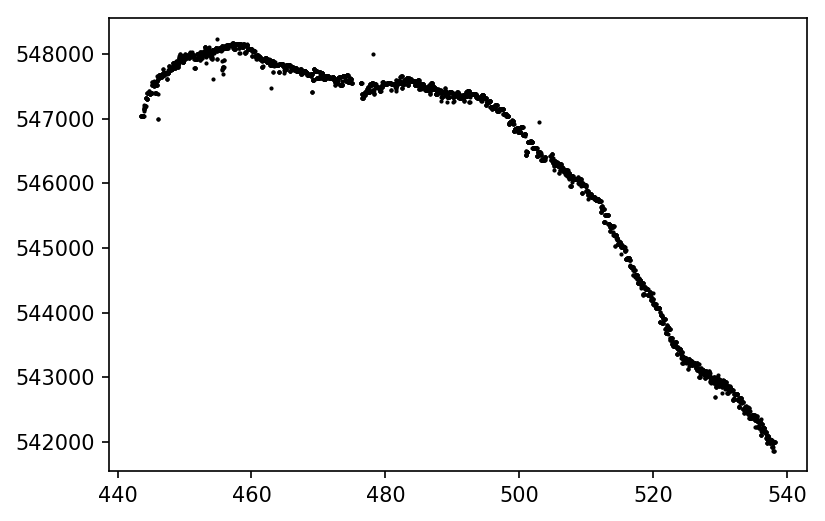

In [45]:
plt.plot(tpf.time, psf_flux, 'ko', markersize=1)

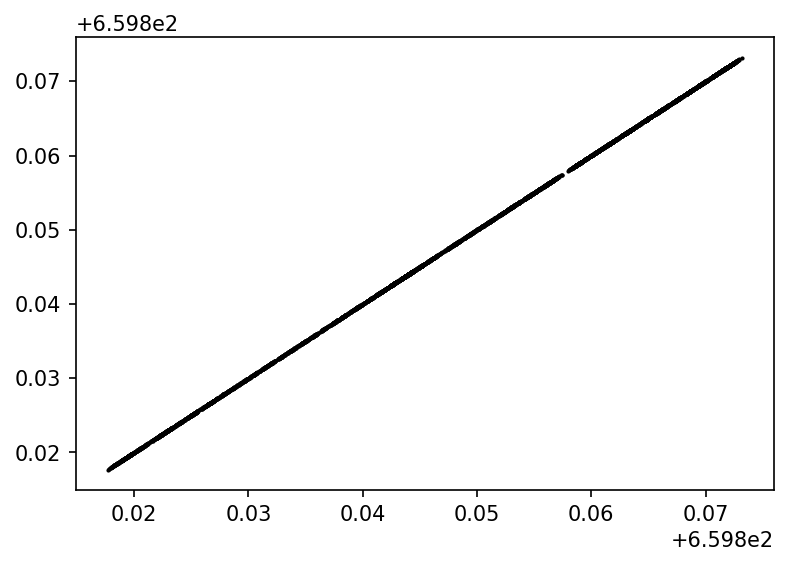

In [36]:
plt.plot(psf_yc, psf_xc, 'ko', markersize=1)

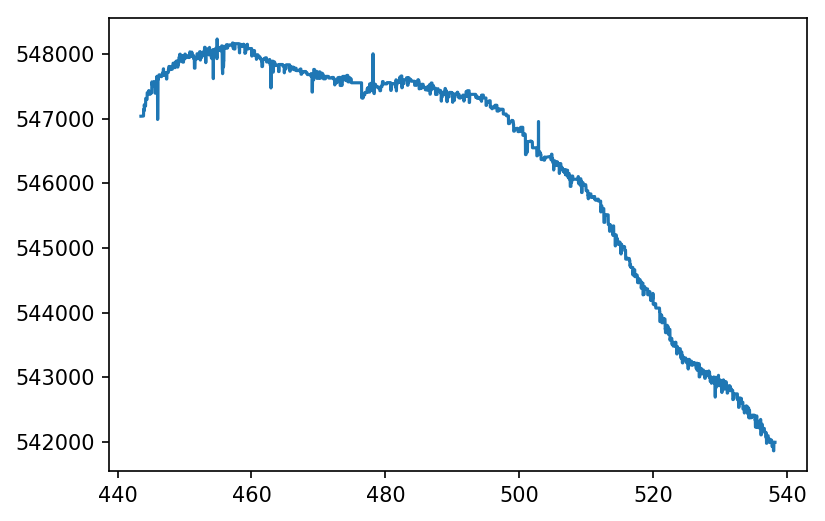

In [25]:
plt.plot(tpf.time, psf_flux)

In [26]:
lc = tpf.to_lightcurve()

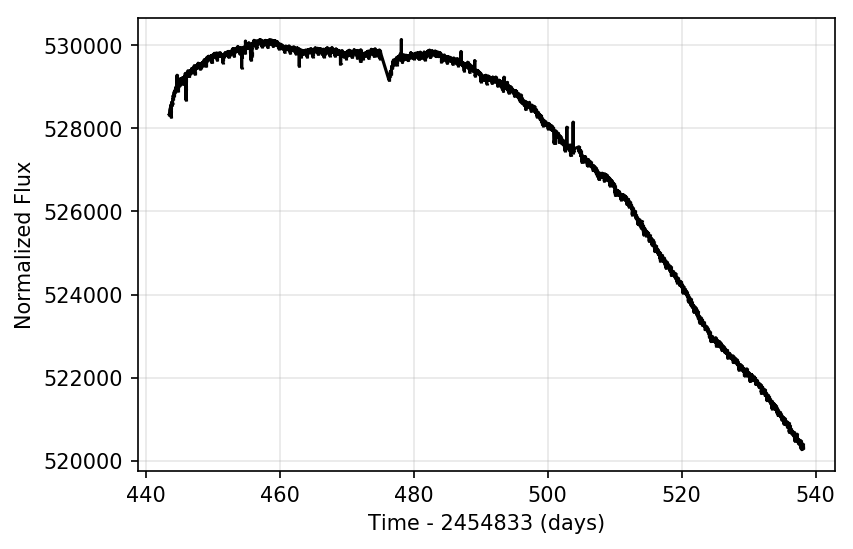

In [27]:
lc.plot(normalize=False)

In [29]:
from lightkurve import LightCurve

In [30]:
lc_psf = LightCurve(tpf.time, psf_flux).flatten()

In [31]:
lc = tpf.to_lightcurve().flatten()

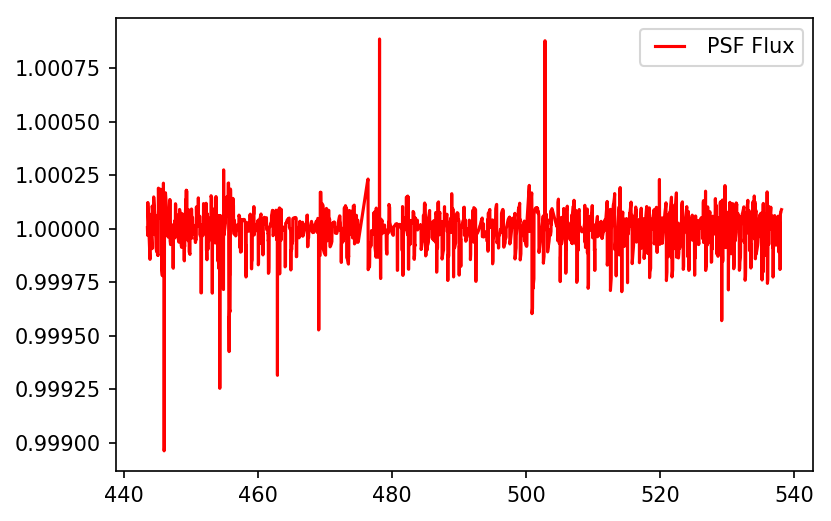

In [34]:
plt.plot(lc_psf.time, lc_psf.flux, 'r', markersize=1, label='PSF Flux')
#plt.plot(lc.time, lc.flux, 'ko', markersize=1, label='Aperture Flux')
plt.legend(numpoints=3)

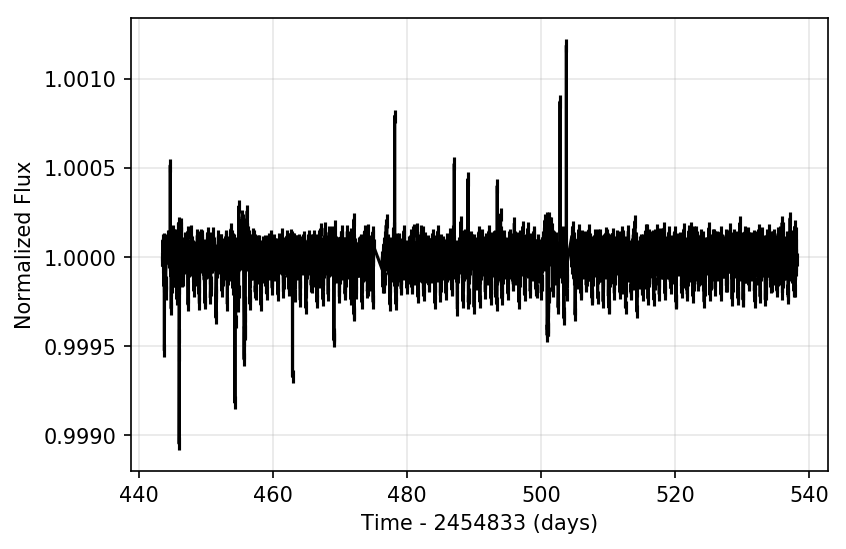

In [33]:
tpf.to_lightcurve().flatten().plot()

In [23]:
from vaneska.interpolate import ScipyRectBivariateSpline
import tensorflow as tf

In [24]:
y, x = np.mgrid[0:10:1j*100, 0:7:1j*100]
z = x ** 2 + y ** 2

In [25]:
interp = ScipyRectBivariateSpline(x[0], y[:, 0], z)

In [26]:
xc = tf.Variable(7., dtype=tf.float64)
yc = tf.Variable(3., dtype=tf.float64)

In [27]:
xc

<tf.Variable 'Variable_4:0' shape=() dtype=float64_ref>

In [28]:
xc

<tf.Variable 'Variable_4:0' shape=() dtype=float64_ref>

In [40]:
xt = tf.Variable(np.linspace(0., 10., 100), dtype=tf.float64)
yt = tf.Variable(np.linspace(0., 10., 99), dtype=tf.float64)

In [41]:
img = interp(xt - xc, yt - yc)

In [42]:
sess = tf.Session()

In [43]:
sess.run(tf.global_variables_initializer())

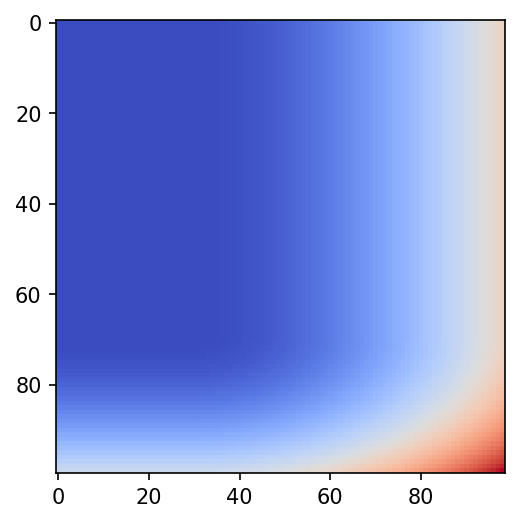

In [44]:
plt.imshow(sess.run(img), cmap='coolwarm')

In [54]:
grad = tf.gradients(img, [yt])

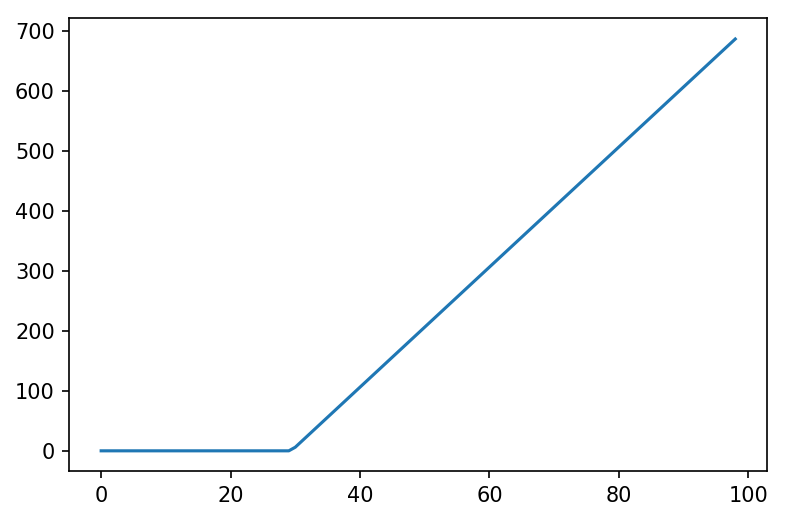

In [55]:
plt.plot(sess.run(grad)[0])

In [39]:
tf.reduce_sum()

TypeError: reduce_sum() missing 1 required positional argument: 'input_tensor'

In [ ]:
tf.py_func()

In [ ]:
tf.py_func()

In [ ]:
sess.run(grad)

In [ ]:
np.array()

In [ ]:
np.reshape(np.ones((11, 11)), -1).shape

In [ ]:
grad = tf.reshape(grad, shape=(100,))

In [ ]:
sess.run(grad)

In [ ]:
len(sess.run(grad)[0])

In [ ]:
xc

In [ ]:
sess.run(grad)

In [ ]:
xc = tf.linspace(0., 10., 10)
yc = tf.linspace(0., 10., 10)

In [ ]:
sess.run(diff)

In [ ]:
diff = tf.subtract(tf.constant(np.ones(10), dtype=tf.float64), tf.constant(1., dtype=tf.float64))

In [ ]:
model